In [2]:
import torch as t
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM, Conv1D, Flatten, Dropout,Dense,Activation
from tensorflow.keras.optimizers import RMSprop

import numpy as np
from google.colab import drive
import re
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
def load_deap_pkl(dirr):
    """Open pickled deap dict. Label order: valence, arousal, dominance, liking"""
    with open(dirr, 'rb') as f:
      data= pickle.load(f)
    return data

def wierd_split(x,y,split):
    split_size=int(x.shape[2]/split)
    x_ext=t.zeros(int(x.shape[0]*split),int(split_size*x.shape[1]))
    y_ext=t.zeros(int(x.shape[0]*split),1)
    
    for i in range(x.shape[0]):
      for h in range(split):
          x_t=x[i,0,h*split_size:(h+1)*split_size]
          for j in range(1,x.shape[1]):       
              temp=x[i, j, h*split_size:(h+1)*split_size]
              x_t=t.cat((x_t,temp),0)
      x_ext[h+i*split]=x_t

      if i==0:
        if y[i]==1:
            y_ext[0:split]=1
        else:
            y_ext[0:split]=0
      else:
        if y[i]==1:
            y_ext[i*split:(i+1)*split]=1
        else:
            y_ext[i*split:(i+1)*split]=0
    
    x_ext=x_ext.reshape(int(x.shape[0]*split),1,int(split_size*x.shape[1]))
    print(x_ext.shape,y_ext.shape,y.sum()/y.shape[0]==y_ext.sum()/y_ext.shape[0])
    return x_ext,y_ext

def data_split_n_extend(x,y,split):
    new_n=int(x.shape[0]*split)
    new_seq=int(x.shape[2]/split)
    ch=x.shape[1]
    x_ext=x.view(new_n,new_seq,ch)
    y_ext=t.zeros(new_n,1)

    for i in range(x.shape[0]):
        if i==0:
            if y[i]==1:
                y_ext[0:split]=1
            else:
                y_ext[0:split]=0
        else:
            if y[i]==1:
                y_ext[i*split:i*split*2]=1
            else:
                y_ext[i*split:i*split*2]=0

    print(x_ext.shape,x_ext.dtype,y_ext.shape,y_ext.dtype,y_ext.sum()/y_ext.shape[0]==y.sum()/y.shape[0])

    return x_ext,y_ext

In [3]:
deap=load_deap_pkl('/content/drive/MyDrive/Exjobb_Filip_Modulai/DEAP_EEG/deap.pkl')
x=deap['x']
y=deap['y'][:,3]
y=(y>=5).to(int)
print(x.shape,y.shape)

torch.Size([1280, 32, 8064]) torch.Size([1280])


In [4]:
x,y=wierd_split(x,y,12)

torch.Size([15360, 1, 21504]) torch.Size([15360, 1]) tensor(True)


In [5]:
def wierd_lstm(input_shape):
  tf.keras.backend.clear_session()

  in_lay=Input(shape=(input_shape))

  x=LSTM(64,return_sequences=True)(in_lay)
  x=Activation('relu')(x)

  x=Dropout(0.2)(x)

  x=LSTM(32)(x)
  x=Activation('sigmoid')(x)

  x=Dense(1)(x)
  out_lay=Activation('sigmoid')(x)

  model= Model(inputs=in_lay,outputs=out_lay)
  model.summary()
  return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 21504)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             5521664   
_________________________________________________________________
activation (Activation)      (None, 1, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

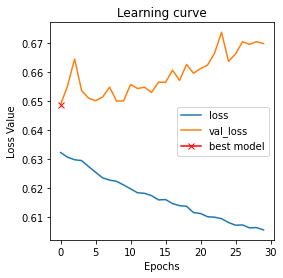

In [6]:
input_shape=(1,21504)
bs=8
lr=0.001
n_ep=30


model=wierd_lstm(input_shape)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = RMSprop(learning_rate=lr),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

model_hist = model.fit(x.numpy(),
                       y.numpy(),
                       validation_split=0.25,
                       epochs=n_ep,
                       batch_size=bs,
                       verbose=1,
                       shuffle=True)

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(model_hist.history["loss"], label="loss")
plt.plot(model_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_hist.history["val_loss"]),
np.min(model_hist.history["val_loss"]),
marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();

In [14]:

deap=load_deap_pkl('/content/drive/MyDrive/Exjobb_Filip_Modulai/DEAP_EEG/deap.pkl')
x=deap['x']
y=deap['y'][:,3]
y=(y>=5).to(int)
print(x.shape,y.shape)

torch.Size([1280, 32, 8064]) torch.Size([1280])


In [15]:
x,y=data_split_n_extend(x,y,12)

torch.Size([15360, 672, 32]) torch.float32 torch.Size([15360, 1]) torch.float32 tensor(True)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 672, 32)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 672, 64)           24832     
_________________________________________________________________
activation (Activation)      (None, 672, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 672, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

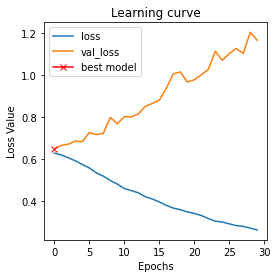

In [16]:
input_shape=(672,32)
bs=8
lr=0.001
n_ep=30


model=wierd_lstm(input_shape)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = RMSprop(learning_rate=lr),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

model_hist = model.fit(x.numpy(),
                       y.numpy(),
                       validation_split=0.25,
                       epochs=n_ep,
                       batch_size=bs,
                       verbose=1,
                       shuffle=True)

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(model_hist.history["loss"], label="loss")
plt.plot(model_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_hist.history["val_loss"]),
np.min(model_hist.history["val_loss"]),
marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();